<a href="https://colab.research.google.com/github/g-r-a-e-m-e/essential-math-for-data-science/blob/main/chapter_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 06
## Logistic Regression and Classification

### Performing a Logistic Regression

#### Logistic Function

$y = {\displaystyle \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x)}}}$

In [ ]:
# Example 6-1. The logistic function
import math

# Define function to predict probability
def predict_probability(x, b0, b1):
  p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
  return p

1.0/(1.0 + 16.8272567955368*exp(-0.62*x))


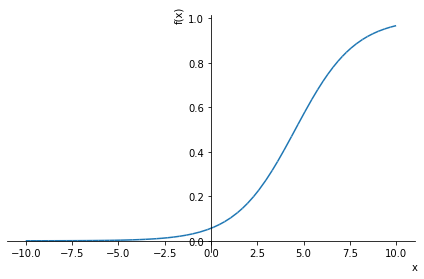

In [ ]:
# Example 6-2. Using SymPy to plot a logistic function
from sympy import *
b0, b1, x = symbols('b0 b1 x')

p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))

p = p.subs(b0, -2.823)
p = p.subs(b1, 0.620)
print(p)

plot(p)

Alternative logistic function

$p = {\displaystyle \frac{e^{\beta_0 + \beta_1 x}}{1.0 + e^{\beta_0 + \beta_1 x}}}$

Extending logistic function to more variables

$p = {\displaystyle \frac{1.0}{e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_n x_n)}}}$

#### Fitting the Logistic Curve


##### Using SciPy

[0.69267212]
[-3.17576395]


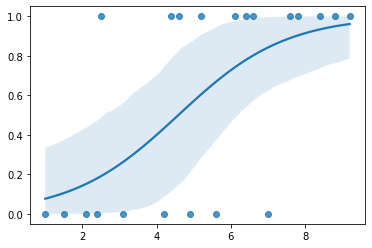

In [ ]:
# Example 6-3. Using a plain logistic regression in SciPy
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Load data
df = pd.read_csv('https://bit.ly/33ebs2R', delimiter = ',')

# Extract input variables
X = df.values[:, :-1]

# Extract output column
y = df.values[:, -1]

# Perform logistic regression
model = LogisticRegression(penalty = 'none')

# Fit model
model.fit(X, y)

# Print beta_1
print(model.coef_.flatten())

# Print beta_0
print(model.intercept_.flatten())

# Plot results
sns.regplot(x = X, y = y, data = df, logistic = True)

##### Using Maximum Likelihood and Gradient Descent

In [ ]:
# Example 6-4. Calculating the joint likelihood for a given logistic regression
import math
import pandas as pd

# Import data
patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter = ',').itertuples()

# Set beta coefficients
b0 = -3.17576395
b1 = 0.69267212

# Define logistic function
def logistic_function(x):
  p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
  return p

# Calculate joint likelihood
joint_likelihood = 1.0

for p in patient_data:
  if p.y == 1.0:
    joint_likelihood *= logistic_function(p.x)
  elif p.y == 0.0:
    joint_likelihood *= (1.0 - logistic_function(p.x))

# Print results
print(joint_likelihood)

4.7911180221699105e-05


$\text{joint likelihood} = {\displaystyle \prod_{i = 1}^n 
\left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{y_i} 
\times 
\left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{1.0 - y_i}}$

In [ ]:
# Example 6-5. Compressing the joint likelihood function without an if
for p in patient_data:
  joint_likelihood *= logistic_function(p.x) ** p.y *\
                      (1.0 - logistic_function(p.x) ** (1.0 - p.y))

print(joint_likelihood)

4.7911180221699105e-05


In [ ]:
# Example 6-6. Using logarithmic addition
# Calculate the joint likelihood
joint_likelihood = 0.0

for p in patient_data:
  joint_likelihood += math.log(logistic_function(p.x) ** p.y * \
                              (1.0 - logistic_function(p.x)) ** (1.0 - p.y))

joint_likelihood = math.exp(joint_likelihood)

print(joint_likelihood)

1.0


$\text{joint likelihood} = 
{\displaystyle 
\sum_{i = 1}^n \log 
\left( 
  \left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{y_i} 
  \times 
  \left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{1.0 - y_i}
\right)}
$

In [ ]:
# Example 6-7. Expressing a joint likelihood for a logistic regression in SymPy
#joint_likelihood = Sum(log((1.0 / (1.0 + exp(-(b + m * x(i))))) ** y(i) \
#                           (1.0 - (1.0 / (1.0 + exp(-(b + m * x(i)))))) ** (1 - y(i))), (i, 0, n))

In [ ]:
# Example 6-8. Using gradient descent on logistic regression
from sympy import *
import pandas as pd

# Import data
points = list(pd.read_csv('https://tinyurl.com/y2cocoo7').itertuples())

# Declare variables
b1, b0, i, n = symbols('b1 b0 i n')
x, y = symbols('x y', cls = Function)

joint_likelihood = Sum(log((1.0 / (1.0 + exp(-(b0 + b1 * x(i))))) ** y(i) \
                          * (1.0 - (1.0 / (1.0 + exp(-(b0 + b1 * x(i)))))) ** (1 - y(i))), (i, 0, n))

# Partial derivative for m, with points substituted
d_b1 = diff(joint_likelihood, b1) \
                  .subs(n, len(points) - 1).doit() \
                  .replace(x, lambda i: points[i].x) \
                  .replace(y, lambda i: points[i].y)

# Partial derivative for m, with points substituted
d_b0 = diff(joint_likelihood, b0) \
                  .subs(n, len(points) - 1).doit() \
                  .replace(x, lambda i: points[i].x) \
                  .replace(y, lambda i: points[i].y)

# Compile using lambdify for faster computation
d_b1 = lambdify([b1, b0], d_b1)
d_b0 = lambdify([b1, b0], d_b0)

# Perform gradient descent
b1 = 0.01
b0 = 0.01
L = 0.01

for j in range(10000):
  b1 += d_b1(b1, b0) * L
  b0 += d_b0(b1, b0) * L

print(b1, b0)

0.6926693075370812 -3.175751550409821


### Multivariable Logistic Regression

$y = {\displaystyle \frac{1.0}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_n x_n)}}}$

In [ ]:
# Example 6-9. Multivariable logistic regression
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Import data
employee_data = pd.read_csv('https://tinyurl.com/y6r7qjrp')

# Get inputs
inputs = employee_data.iloc[:, :-1]

# Get output variable
output = employee_data.iloc[:, -1]

# Build logistic regression
fit = LogisticRegression(penalty = 'none').fit(inputs, output)

# Print coefficients
print(f"Coefficients: {fit.coef_.flatten()}")
print(f"Intercept: {fit.intercept_.flatten()}")

# Test with new employee data
def predict_employee_will_stay(sex, age, promotions, years_employed):
  prediction = fit.predict([[sex, age, promotions, years_employed]])
  probabilities = fit.predict_proba([[sex, age, promotions, years_employed]])
  if prediction == 1:
    return f"WILL LEAVE: {probabilities}"
  else:
    return f"WILL STAY: {probabilities}"

# Test a prediction
#while True:
#  n = input("Predict an employee will stay or leave {sex}, {age}, {promotions}, {years_employed}: ")
#  (sex, age, promotions, years_employed) = n.split(',')
#  print(predict_employee_will_stay(int(sex), int(age), int(promotions), int(years_employed)))

Coefficients: [ 0.03213405  0.03682453 -2.50410028  0.9742266 ]
Intercept: [-2.73485302]


### Understanding the Log-Odds

$p = {\displaystyle \frac{1.0}
{1.0 + e^{-(\beta_0 + \beta_1 x)}}}$

$\text{odds} = {\displaystyle \frac{p}{1 - p}}$ 

$\text{logit} = {\displaystyle \log \left( \frac{p}{1 - p} \right)}$

$\text{log-odds} = {\displaystyle \beta_0 + \beta_1 x}$

${\displaystyle \log \left( \frac{p}{1 - p} \right) = \beta_0 + \beta_1 x}$

### R-Squared

${R^2} = {\displaystyle \frac{(\text{log likelihood}) - (\text{log likelihood fit})}{\text{(log likelihood)}}}$

In [ ]:
# Example 6-10. Calculating the log likelihood of the fit
from math import log, exp
import pandas as pd

# Import data
patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter = ',').itertuples()

# Intercept and coefficient
b0 = -3.17576395
b1 = 0.69267212

# Define logistic function
def logistic_function(x):
  p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))
  return p

# Sum the log likelihoods
log_likelihood_fit = 0.0

for p in patient_data:
  if p.y == 1.0:
    log_likelihood_fit += log(logistic_function(p.x))
  elif p.y == 0.0:
    log_likelihood_fit += log(1.0 - logistic_function(p.x))

# Print results
print(log_likelihood_fit)

-9.946161673231583


In [ ]:
# Example 6-11. Consolidating log likelihood into a single line
log_likelihood_fit = sum((log(logistic_function(p.x)) * p.y) + \
                         (log(1.0 - logistic_function(p.x)) * (1.0 - p.y)) \
                         for p in patient_data)

print(log_likelihood_fit)

0


$\text{log likelihood fit} = \displaystyle \sum_{i = 1}^n 
\left( log(f_{x_i}) \times y_i \right) 
+ \left( log(1.0 - f(x_i)) \times (1 - y_i) \right)$


$\text{log likelihood} = \displaystyle \frac{\sum y_i}{n} 
\times y_i + 
\left( 1 - \frac{\sum y_i}{n} \right)
\times (1 - y_i)$

In [ ]:
# Example 6-12. Log likelihood
import pandas as pd
from math import log, exp

# Import data
patient_data = list(pd.read_csv('https://bit.ly/33ebs2R', delimiter = ',').itertuples())

# Calculate likelihood
likelihood = sum(p.y for p in patient_data) / len(patient_data)

# Set log likelihood variable
log_likelihood = 0.0

# Initialize loop
for p in patient_data:
  if p.y == 1.0:
    log_likelihood += log(likelihood)
  elif p.y == 0.0:
    log_likelihood += log(1.0 - likelihood)

# Print results
print(log_likelihood)

-14.341070198709906
